In [1]:
import tensorflow as tf
import levenberg_marquardt as lm
import scipy.stats
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import seaborn as sns
from glob import glob
import xarray as xr
import typhon as ty
import sys
sys.path.append('/home/u/u301238/master_thesis/')
import src

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

2023-05-11 21:35:17.109420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 21:35:17.624030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-11 21:35:17.624277: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-11 21:35:19.631896: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Load an preprocess training data

#### Create new set of training data

In [2]:
altitude = 12000

# load training data
TBs, frozen_water, liquid_water, IWV = src.load_nn_training_data(altitude=altitude)
IWP = frozen_water[3,:]
LWP = liquid_water[2,:]

# exclude profiles closer than 5km to ICON-HALO collocated profiles
collocation_profiles_mask = np.load('/home/u/u301238/master_thesis/nn/collocation_profiles_mask.npy')
TBs = TBs[collocation_profiles_mask==0]
IWP = IWP[collocation_profiles_mask==0]
LWP = LWP[collocation_profiles_mask==0]
IWV = IWV[collocation_profiles_mask==0]

# exclude profiles with unrealistic pamtra simulations
TBs[TBs[:,20]<230] = np.nan
TB_input_vector = TBs[~np.isnan(TBs).any(axis=1),:]
IWP = IWP[~np.isnan(TBs).any(axis=1)]
LWP = LWP[~np.isnan(TBs).any(axis=1)]
IWV = IWV[~np.isnan(TBs).any(axis=1)]

# set IWP values below 1gm2 to zero
IWP[IWP<1.]=0.

# concatenate TB vector manually
TB_input_vector = np.concatenate((
        TB_input_vector[:,0:7], # K-Band
        TB_input_vector[:,7:14], # V-Band
        TB_input_vector[:,14:15], # W-Band
        TB_input_vector[:,15:19], # F-Band
        TB_input_vector[:,19:]), # G-Band
        axis=1)
    
# split training data into train and test subsets
#TBs_train, TBs_test, IWP_train, IWP_test  = src.split_nn_training_data(TB_input_vector,IWP,split_ratio=0.75)
TBs_train, TBs_test, IWP_train, IWP_test, LWP_train, LWP_test, IWV_train, IWV_test = src.split_nn_training_data(TB_input_vector,IWP,LWP=LWP,IWV=IWV,split_ratio=0.75)
# standardize all TBs along their respective channel
# as a normal distribution with mean 0 and std of 1
TBs_train_scaled, mu_train, sigma_train = src.standardize_nn_training_data(TBs_train)
TBs_test_scaled = src.standardize_nn_input_data_v2(TBs_test,mu=mu_train,sigma=sigma_train)

In [3]:
collocation_profiles_mask = np.load('/home/u/u301238/master_thesis/nn/collocation_profiles_mask.npy')
len(collocation_profiles_mask[collocation_profiles_mask==1])

982

In [4]:
64000-982

63018

#### Definition & compilation of network

In [3]:
# General settings of the neural network
NR_of_NEURONS_L1 = 32
BIAS_INIT = 'zeros'
WEIGHT_INIT = 'random_normal'
ACTIVATION_HL = 'tanh'
ACTIVATION_OP = 'linear'
LOSS_FUNCTION = tf.keras.losses.MeanSquaredError()
LEARNING_RATE = 0.001

EPOCHS = 1000
BATCH_SIZE = 50

In [4]:
# define & compile nn-model for iwp with specified settings
# * 1 input layer (24 neurons) 
# * 1 hidden layer (64 neurons)
# * 1 output layer (1 neuron)

dnn_model_iwp = tf.keras.Sequential([
    tf.keras.layers.Dropout(rate=0.05, input_shape=(TBs_train.shape[1],)),
    tf.keras.layers.Dense(NR_of_NEURONS_L1,
                          input_shape=(TBs_train.shape[1],),
                          bias_initializer=BIAS_INIT,
                          kernel_initializer=WEIGHT_INIT,
                          kernel_regularizer="l2",
                          activation=ACTIVATION_HL,
                         ),
    tf.keras.layers.Dense(1,
                          activation=ACTIVATION_OP)])

dnn_model_iwp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                      loss=LOSS_FUNCTION,
                     )

dnn_model_iwp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense (Dense)               (None, 32)                800       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


#### Training of IWP neural network

CPU times: user 1min 55s, sys: 5.24 s, total: 2min
Wall time: 1min 32s


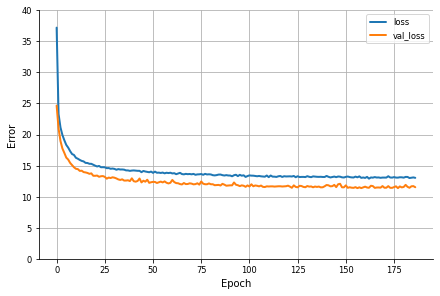

In [5]:
%%time
history = dnn_model_iwp.fit(
    TBs_train_scaled, np.sqrt(IWP_train),
    validation_split=0.2,
    verbose=0,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)]
)

# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim(0,40)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

#plt.savefig('/home/u/u301238/master_thesis/plots/NN/NN_IWP_training_error_loss_24-32-1.jpg',bbox_inches='tight',dpi=200)

### NN-IWP performance on PAMTRA test dataset

In [8]:
# predict sqrt(IWP) with neural network for given TBs
IWP_test_predictions = dnn_model_iwp.predict(TBs_test_scaled)[:,0]
# clip neural network output / predictions (set negative values to zero)
IWP_test_predictions_cliped = src.clip_nn_output(IWP_test_predictions)
# retransform neural network predictions from sqrt to linear LWP values
IWP_test_predictions_squared = IWP_test_predictions_cliped**2

489/489 [==============================] - 0s 478us/step
Negative predictions: 1.45 %


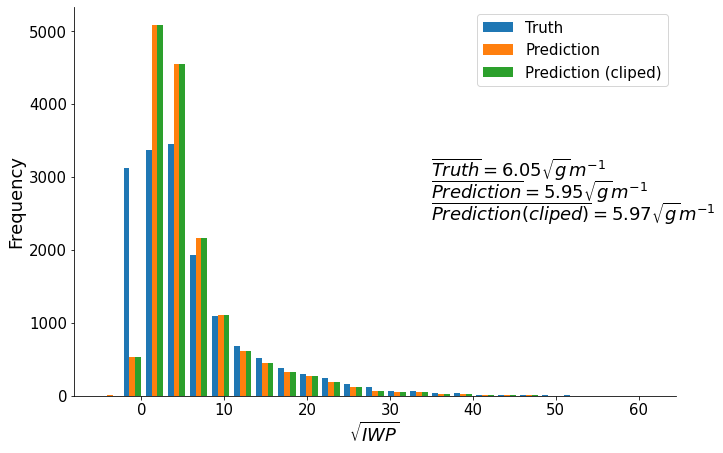

In [27]:
# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

fig, ax = plt.subplots()

labels = [
    f"Truth",
    "Prediction",
    "Prediction (cliped)"]
ax.hist(np.array([np.sqrt(IWP_test),IWP_test_predictions,IWP_test_predictions_cliped]).T,bins=25,label=labels)
ax.text(35.,3000,"$\overline{Truth}=$"+str(np.round(np.nanmean(np.sqrt(IWP_test)),2))+"$\sqrt{g}m^{-1}$",ha="left")
ax.text(35.,2700,"$\overline{Prediction}=$"+str(np.round(np.mean(IWP_test_predictions),2))+"$\sqrt{g}m^{-1}$",ha="left")
ax.text(35.,2400,"$\overline{Prediction (cliped)}=$"+str(np.round(np.mean(IWP_test_predictions_cliped),2))+"$\sqrt{g}m^{-1}$",ha="left")
ax.set_xlabel("$\sqrt{IWP}$")
ax.set_ylabel("Frequency")
plt.legend()

#plt.savefig('/home/u/u301238/master_thesis/plots/NN/NN_IWP_predictions_cliping_effect.jpg',bbox_inches='tight',dpi=200)

Bias: 0.11
RMSE: 0.56
Corr: 0.78


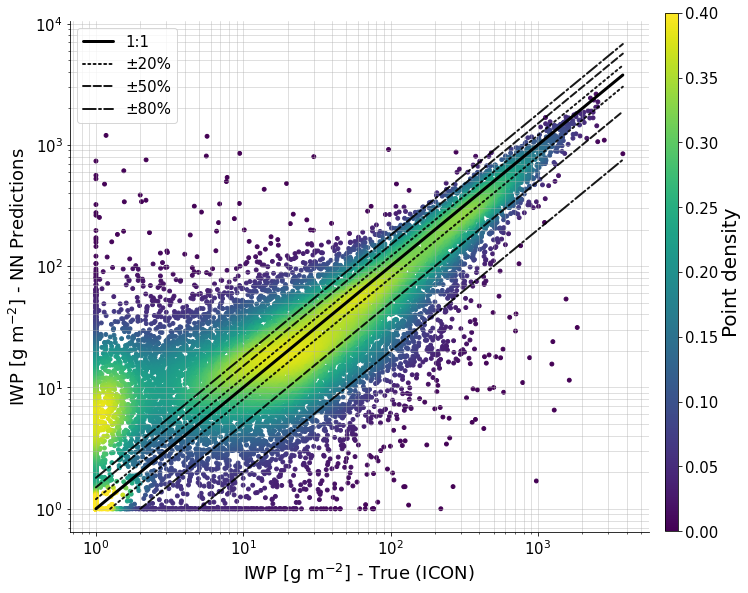

In [9]:
# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

kind = 'log'

fig, axs = plt.subplots(figsize=(9,8))

if kind == 'linear':
    
    a = IWP_test
    b = IWP_test_predictions_squared
    
    a[a<1.] = 0
    b[b<1.] = 0
    
    #a[a<1.] = np.nan
    #b[b<1.] = np.nan
    
if kind == 'log':
    
    IWP_test_log = IWP_test.copy()
    IWP_test_log[IWP_test_log==0] = 10**(-16)
    IWP_test_predictions_squared_log = IWP_test_predictions_squared.copy()
    IWP_test_predictions_squared_log[IWP_test_predictions_squared_log==0] = 10**(-16)
    
    a = np.log10(IWP_test_log)
    b = np.log10(IWP_test_predictions_squared_log)
    
    a[a<0.] = 0
    b[b<0.] = 0
    
    #a[a<0.] = np.nan
    #b[b<0.] = np.nan
    
    #a = IWP_test.copy()
    #b = IWP_test_predictions_squared.copy()
    
    #a[a<1.] = 1.
    #b[b<1.] = 1.
    
if kind == 'sqrt':
    
    a = np.sqrt(IWP_test)
    b = IWP_test_predictions

nans = np.logical_or(np.isnan(a), np.isnan(b))
a = a[~nans]
b = b[~nans]

maxval = max(np.max(a),np.max(b))
minval = max(np.min(a),np.min(b))
    
# Calculate the point density
ab = np.vstack([a,b])
c = scipy.stats.gaussian_kde(ab)(ab)

# Sort the points by density, so that the densest points are plotted last
idx = c.argsort()
a, b, c = a[idx], b[idx], c[idx]

bias = np.round((np.mean(b) - np.mean(a)),2)
corr = np.round((scipy.stats.pearsonr(a,b)[0]),2)
rmse = np.round(np.sqrt(np.nanmean((b-a)**2)),2)

axs.grid(alpha=0.5,which='both')

iwp_true = np.arange(1,np.nanmax(IWP_test),0.01)
RE_80_plus = (0.8*iwp_true)+iwp_true
RE_80_minus = (-0.8*iwp_true)+iwp_true
RE_50_plus = (0.5*iwp_true)+iwp_true
RE_50_minus = (-0.5*iwp_true)+iwp_true
RE_20_plus = (0.2*iwp_true)+iwp_true
RE_20_minus = (-0.2*iwp_true)+iwp_true
RE_20_minus[RE_20_minus<1.]=np.nan
RE_50_minus[RE_50_minus<1.]=np.nan
RE_80_minus[RE_80_minus<1.]=np.nan
  
#axs.scatter(y_test, y_test_predictions**2)
if kind == 'linear':
    sc = axs.scatter(a,b,c=c,s=5,cmap='viridis',vmin=np.min(c),vmax=0.00004)
    axs.plot(np.arange(0,maxval),np.arange(0,maxval),linewidth=3,color='black',alpha=1,label='1:1')
    axs.plot(iwp_true,RE_20_plus,linewidth=2,linestyle='dotted',color='black',alpha=0.5,label='±20%')
    axs.plot(iwp_true,RE_20_minus,linewidth=2,linestyle='dotted',color='black',alpha=0.5)
    axs.plot(iwp_true,RE_50_plus,linewidth=2,linestyle='dashed',color='black',alpha=0.5,label='±50%')
    axs.plot(iwp_true,RE_50_minus,linewidth=2,linestyle='dashed',color='black',alpha=0.5)
    axs.plot(iwp_true,RE_80_plus,linewidth=2,linestyle='dashdot',color='black',alpha=0.5,label='±80%')
    axs.plot(iwp_true,RE_80_minus,linewidth=2,linestyle='dashdot',color='black',alpha=0.5)
    
    axs.set_xlabel('IWP [g m$^{-2}$] - True (ICON)')
    axs.set_ylabel('IWP [g m$^{-2}$] - NN Predictions')
    axs.set_ylim(top=3200)
    axs.set_xlim(right=3200)
    
if kind == 'log':
    sc = axs.scatter(10**a,10**b,c=c,s=15,cmap='viridis',vmin=0,vmax=0.4)
    #sc = axs.scatter(a,b,c=c,s=8,cmap='viridis',vmin=np.min(c),vmax=np.max(c))
    axs.plot(np.arange(10**0,10**maxval),np.arange(10**0,10**maxval),linewidth=3,color='black',alpha=1,label='1:1')
    #axs.plot(np.arange(0,maxval),np.arange(0,maxval),linewidth=3,color='black',alpha=1,label='1:1')
    axs.plot(iwp_true,RE_20_plus,linewidth=2,linestyle='dotted',color='black',alpha=0.9,label='±20%')
    axs.plot(iwp_true,RE_20_minus,linewidth=2,linestyle='dotted',color='black',alpha=0.9)
    axs.plot(iwp_true,RE_50_plus,linewidth=2,linestyle='dashed',color='black',alpha=0.9,label='±50%')
    axs.plot(iwp_true,RE_50_minus,linewidth=2,linestyle='dashed',color='black',alpha=0.9)
    axs.plot(iwp_true,RE_80_plus,linewidth=2,linestyle='dashdot',color='black',alpha=0.9,label='±80%')
    axs.plot(iwp_true,RE_80_minus,linewidth=2,linestyle='dashdot',color='black',alpha=0.9)
    
    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.set_xlabel('IWP [g m$^{-2}$] - True (ICON)')
    axs.set_ylabel('IWP [g m$^{-2}$] - NN Predictions')
    #axs.set_ylim(bottom=1)
    #axs.set_xlim(left=1)

if kind == 'sqrt':
    sc = axs.scatter(a,b,c=c,s=15,cmap='viridis',vmin=np.min(c),vmax=np.max(c))
    axs.plot(np.arange(0,maxval),np.arange(0,maxval),linewidth=2,color='black',alpha=0.5)
    axs.set_xlabel('$\sqrt{IWP}$ [$\sqrt{g}m^{-1}$] - True (ICON)')
    axs.set_ylabel('$\sqrt{IWP}$ [$\sqrt{g}m^{-1}$] - NN predictions')
    
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.9])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('Point density',size=20)
axs.legend()

#axs.text(0.02, 0.8, 'Bias: '+str(bias), 
#         transform=axs.transAxes, fontsize=20,
#         verticalalignment='top')
#axs.text(0.05, 0.885, 'RMSE: '+str(rmse), 
#         transform=axs.transAxes, fontsize=20,
#         verticalalignment='top')
#axs.text(0.05, 0.81, 'Corr: '+str(corr), 
#         transform=axs.transAxes, fontsize=20,
#         verticalalignment='top')

print('Bias: '+str(bias))
print('RMSE: '+str(rmse))
print('Corr: '+str(corr))

#plt.savefig('/home/u/u301238/master_thesis/plots/NN/NN_24_32_1_reg_12000m_testdata_scatterdensity_linear.jpg',bbox_inches='tight',dpi=200)

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/seaborn/axisgrid.py:1740: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


Text(37.25, 0.5, 'Retrieved IWP [g m$^{-2}$]')

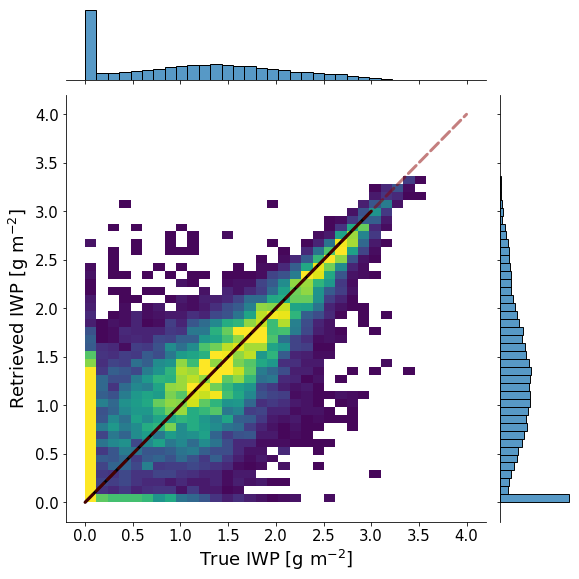

In [29]:
kind = 'log'

if kind == 'linear':
    
    a = IWP_test
    b = IWP_test_predictions_squared
    
    a[a<1.] = 0
    b[b<1.] = 0
    
    #a[a<1.] = np.nan
    #b[b<1.] = np.nan
    
if kind == 'log':
    
    IWP_test_log = IWP_test.copy()
    IWP_test_log[IWP_test_log==0] = 10**(-16)
    #IWP_test_log[IWP_test_log<1] = np.nan
    IWP_test_predictions_squared_log = IWP_test_predictions_squared.copy()
    IWP_test_predictions_squared_log[IWP_test_predictions_squared_log==0] = 10**(-16)
    #IWP_test_predictions_squared_log[IWP_test_predictions_squared_log<1] = np.nan
    
    a = np.log10(IWP_test_log)
    b = np.log10(IWP_test_predictions_squared_log)
    
    a[a<0.] = 0
    b[b<0.] = 0
    
    #a[a<0.] = np.nan
    #b[b<0.] = np.nan
    
    #a = IWP_test.copy()
    #b = IWP_test_predictions_squared.copy()
    
    #a[a<1.] = 0.
    #b[b<1.] = 0.
    
if kind == 'sqrt':
    
    a = np.sqrt(IWP_test)
    b = IWP_test_predictions
    
maxval = max(np.nanmax(a),np.nanmax(b))
    
#a[a<0.] = 0
#b[b<0.] = 0

#f, ax = plt.subplots()

#sns.set(color_codes=True)

jp = sns.jointplot(x = a, y = b,
                   kind = "hist", data = None, cmap='viridis',vmin=0, vmax=60, height=8,)
jp.ax_joint.plot(np.arange(0,maxval),np.arange(0,maxval),linewidth=3,color='black',alpha=1,label='1:1')
#jp.ax_joint.plot(iwp_true,RE_20_plus,linewidth=2,linestyle='dotted',color='black',alpha=0.9,label='±20%')
#jp.ax_joint.plot(iwp_true,RE_20_minus,linewidth=2,linestyle='dotted',color='black',alpha=0.9)
#jp.ax_joint.plot(iwp_true,RE_50_plus,linewidth=2,linestyle='dashed',color='black',alpha=0.9,label='±50%')
#jp.ax_joint.plot(iwp_true,RE_50_minus,linewidth=2,linestyle='dashed',color='black',alpha=0.9)
#jp.ax_joint.plot(iwp_true,RE_100_plus,linewidth=2,linestyle='dashdot',color='black',alpha=0.9,label='±100%')
#jp.ax_joint.plot(iwp_true,RE_100_minus,linewidth=2,linestyle='dashdot',color='black',alpha=0.9)
#jp.ax_joint.set_xlim(0,maxval)
#jp.ax_joint.set_ylim(0,maxval)
#jp.ax_joint.set_xscale('log')
#jp.ax_joint.set_yscale('log')
jp.ax_joint.plot(np.arange(0,4.5),np.arange(0,4.5),linewidth=3,linestyle='dashed',color='darkred',alpha=0.5)
jp.ax_joint.set_xlabel('True IWP [g m$^{-2}$]')
jp.ax_joint.set_ylabel('Retrieved IWP [g m$^{-2}$]')
#plt.plot(np.arange(0,maxval),np.arange(0,maxval),linewidth=2,color='black',alpha=0.5)
#plt.xscale('log')
#plt.yscale('log')

#sns.set(color_codes=False)

#plt.savefig('/home/u/u301238/master_thesis/nn/dnn_model_iwp_all_levels/plot')

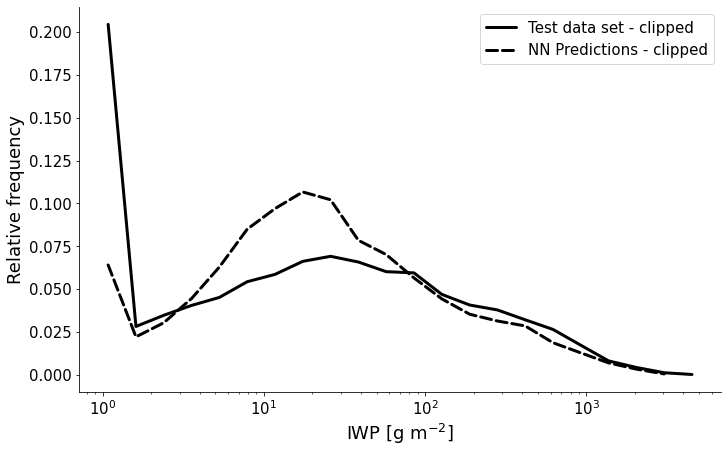

In [16]:
#IWP_test[IWP_test<1] = np.nan
#IWP_test_predictions_squared[IWP_test_predictions_squared<1] = np.nan

IWP_test_predictions_squared_clipped = IWP_test_predictions_squared.copy()
IWP_test_predictions_squared_clipped[IWP_test_predictions_squared_clipped<1.]=1.

IWP_test_clipped = IWP_test.copy()
IWP_test_clipped[IWP_test_clipped<1.]=1.

n_normed_ICON_clipped, ICON_zeros, bins  = src.normed_log10_pdf_v0(IWP_test_clipped,bin_nr=30)
n_normed_NN_clipped, NN_zeros, _ = src.normed_log10_pdf_v0(IWP_test_predictions_squared_clipped,bin_nr=30)
n_normed_ICON, bins  = src.normed_log10_pdf(IWP_test_clipped,bin_nr=30)
n_normed_NN, _ = src.normed_log10_pdf(IWP_test_predictions_squared_clipped,bin_nr=30)

# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

fig, axs = plt.subplots()

axs.plot(10**bins[1:],n_normed_ICON_clipped,linewidth=3,color='black',label='Test data set - clipped')
axs.plot(10**bins[1:],n_normed_NN_clipped,linewidth=3,color='black',linestyle='dashed',label='NN Predictions - clipped')
#axs.plot(10**bins[1:],n_normed_ICON,linewidth=3,color='red',label='Test data set')
#axs.plot(10**bins[1:],n_normed_NN,linewidth=3,color='red',linestyle='dashed',label='NN Predictions')
axs.set_xscale('log')
#axs.set_yscale('log')
axs.legend()
axs.set_ylabel('Relative frequency')
axs.set_xlabel('IWP [g m$^{-2}$]')
xmin,xmax = axs.get_xlim()

#fig.suptitle('PAMTRA test dataset')

#plt.savefig('/home/u/u301238/master_thesis/plots/NN/NN_24_32_1_reg_12000m_testdata_pdf.jpg',bbox_inches='tight',dpi=200)

In [14]:
sns.reset_orig

<function seaborn.rcmod.reset_orig()>

#### Saving NN-IWP model / retrieval to disk

In [14]:
dnn_model_iwp.save(f'/home/u/u301238/master_thesis/nn/dnn_model_iwp_all_levels/dnn_model_iwp_24-32-1_reg_{altitude}m')

# predict sqrt(IWP) with neural network for given TBs
IWP_test_predictions = dnn_model_iwp.predict(TBs_test_scaled)[:,0]
# clip neural network output / predictions (set negative values to zero)
IWP_test_predictions_cliped = src.clip_nn_output(IWP_test_predictions)
# retransform neural network predictions from sqrt to linear LWP values
IWP_test_predictions_squared = IWP_test_predictions_cliped**2

# Saving collocated ICON data to netcdf file
filename = (f'/home/u/u301238/master_thesis/nn/dnn_model_iwp_all_levels/train_test_data_nn_24-32-1_reg_{altitude}m.nc')
ds = Dataset(filename,'w','NETCDF4')

# profile and frequency dimensions
ds.createDimension('train_cases',len(IWP_train))
ds.createDimension('test_cases',len(IWP_test))
ds.createDimension('freq',24)

# TBs
tb_train_var = ds.createVariable('tb_train','float64',('train_cases','freq'))
tb_train_var.long_name = 'ICON-PAMTRA simulated brightness temperatures of training data set'
tb_train_var.setncattr('units','K')
tb_train_var[:,:] = TBs_train[:,:]
tb_test_var = ds.createVariable('tb_test','float64',('test_cases','freq'))
tb_test_var.long_name = 'ICON-PAMTRA simulated brightness temperatures of test data set'
tb_test_var.setncattr('units','K')
tb_test_var[:,:] = TBs_test[:,:]

# IWP
iwp_train_var = ds.createVariable('iwp_train','float64',('train_cases'))
iwp_train_var.long_name = 'ICON simulated IWP values of training data set'
iwp_train_var.setncattr('units','g m2')
iwp_train_var[:] = IWP_train[:]
iwp_test_var = ds.createVariable('iwp_test','float64',('test_cases'))
iwp_test_var.long_name = 'ICON simulated IWP values of test data set'
iwp_test_var.setncattr('units','g m2')
iwp_test_var[:] = IWP_test[:]
iwp_retr_var = ds.createVariable('iwp_retrieved','float64',('test_cases'))
iwp_retr_var.long_name = 'Retrieved IWP values of test data set'
iwp_retr_var.setncattr('units','g m2')
iwp_retr_var[:] = IWP_test_predictions_squared[:]

# LWP
lwp_train_var = ds.createVariable('lwp','float64',('train_cases'))
lwp_train_var.long_name = 'ICON simulated LWP values of training data set'
lwp_train_var.setncattr('units','g m2')
lwp_train_var[:] = LWP_train[:]
lwp_test_var = ds.createVariable('lwp_test','float64',('test_cases'))
lwp_test_var.long_name = 'ICON simulated LWP values of test data set'
lwp_test_var.setncattr('units','g m2')
lwp_test_var[:] = LWP_test[:]

# IWV
iwv_train_var = ds.createVariable('iwv','float64',('train_cases'))
iwv_train_var.long_name = 'ICON simulated IWV values of training data set'
iwv_train_var.setncattr('units','g m2')
iwv_train_var[:] = IWV_train[:]
iwv_test_var = ds.createVariable('iwv_test','float64',('test_cases'))
iwv_test_var.long_name = 'ICON simulated IWV values of test data set'
iwv_test_var.setncattr('units','g m2')
iwv_test_var[:] = IWV_test[:]

ds.close()

INFO:tensorflow:Assets written to: /home/u/u301238/master_thesis/nn/dnn_model_iwp_all_levels/dnn_model_iwp_24-32-1_reg_12500m/assets


INFO:tensorflow:Assets written to: /home/u/u301238/master_thesis/nn/dnn_model_iwp_all_levels/dnn_model_iwp_24-32-1_reg_12500m/assets


489/489 [==============================] - 0s 495us/step
Negative predictions: 1.5 %
